# Minimal Cut Sets (MCS)

The minimal cut set approach aims to find a minimum set of network intervetions that enforce some pre-definde behavior in a metabolic network. It may be used to suppress growth, suppress or enforce the synthesis of a certain product or to couple or decouple metabolic fluxes. For a better conceptional understanding of the MCS approach, please refer to examples <a href='#section_7'>7</a> and <a href='#section_8'>8</a>. Examples 1-5 treat strain design applications in a small network, while <a href='#section_6'>example 6</a> presents a genome-scale strain design computation.

## Prerequisites

For the shown examples, we again load the COBRApy and the StrainDesign packages as well as the small E. coli textbook-network "e_coli_core" and the example network "SmallExample". 
For CNApy users a special <a href='https://github.com/cnapy-org/CNApy-projects/releases/latest/download/e_coli_core_14bdo.zip'>project (e_coli_core_14bdo)</a> is available that contains the modified metabolic network together with strain design files for the various examples which can be loaded from the strain design dialog.

The following steps show how the function ``compute_strain_designs`` is employed to find MCS strain designs:
1) The production pathways, i.e., their metabolites and reactions are added to the model.
2) Analysis tools are used to identify adequate strain design goals.
3) Set up the according strain design problem by specifying two strain design *modules*
4) The strain design function is called, passing the model and the strain design module(s) as function arguments.
5) The results are analyzed.

Step (1) is required for all examples shown hereafter. Steps (2)-(4) are example-dependent. We do step (5) for all examples to verify the computed strain designs.

### 

#### 

##### 1) Add and verify production pathway

In [1]:
import straindesign as sd
import cobra
cobra.Configuration().solver = 'cplex'

ecc = cobra.io.load_model('e_coli_core')
model = cobra.io.read_sbml_model('../../../tests/model_small_example.xml')

# Create copy of model to which pathway will be added
ecc_14bdo = ecc.copy()

# Add metabolites to model
ecc_14bdo.add_metabolites([ cobra.Metabolite('sucsal_c'),# Succinic semialdehyde
                            cobra.Metabolite('4hb_c'),   # 4-Hydroxybutanoate
                            cobra.Metabolite('4hbcoa_c'),# 4-Hydroxybutyryl-CoA
                            cobra.Metabolite('4hbal_c'), # 4-Hydroxybutanal
                            cobra.Metabolite('14bdo_c'), # Butane-1,4-diol (cytopl.)
                            cobra.Metabolite('14bdo_p'), # Butane-1,4-diol (peripl.)
                            cobra.Metabolite('14bdo_e')  # Butane-1,4-diol (extrac.)
                            ])

# Create reactions
SSCOARx    = cobra.Reaction('SSCOARx')
AKGDC      = cobra.Reaction('AKGDC')
HBD        = cobra.Reaction('4HBD')
HBCT       = cobra.Reaction('4HBCT')
HBDH       = cobra.Reaction('4HBDH')
HBDx       = cobra.Reaction('4HBDx')
BDOtpp     = cobra.Reaction('14BDOtpp')
BDOtex     = cobra.Reaction('14BDOtex')
EX_14bdo_e = cobra.Reaction('EX_14bdo_e')

# Add reactions to model
ecc_14bdo.add_reactions([SSCOARx,
                         AKGDC,
                         HBD,
                         HBCT,
                         HBDH,
                         HBDx,
                         BDOtpp,
                         BDOtex,
                         EX_14bdo_e])

# Define reaction equations
SSCOARx.reaction    = '1 h_c + 1 nadph_c + 1 succoa_c -> 1 coa_c + 1 nadp_c + 1 sucsal_c'
AKGDC.reaction      = '1 akg_c + 1 h_c -> 1 co2_c + 1 sucsal_c'
HBD.reaction        = '1 h_c + 1 nadh_c + 1 sucsal_c  -> 1 4hb_c + 1 nad_c'
HBCT.reaction       = '1 4hb_c + 1 accoa_c            -> 1 4hbcoa_c + 1 ac_c'
HBDH.reaction       = '1 4hbcoa_c + 1 h_c + 1 nadh_c  -> 1 4hbal_c + 1 coa_c + 1 nad_c'
HBDx.reaction       = '1 4hbal_c + 1 h_c + 1 nadh_c   -> 1 14bdo_c + 1 nad_c'
BDOtpp.reaction     = '1 14bdo_c                      -> 1 14bdo_p'
BDOtex.reaction     = '1 14bdo_p                      -> 1 14bdo_e'
EX_14bdo_e.reaction = '1 14bdo_e                      ->'

# Verify that pathway is operational
sol = sd.fba(ecc_14bdo,obj='EX_14bdo_e',obj_sense='max')
print(f"Maximum possible 1,4-BDO synthesis rate: {sol.objective_value}.")

Maximum possible 1,4-BDO synthesis rate: 10.252923076923619.


## Example 1: Strain designs with a minimum product (1,4-butanediol) yield (SUCP strain design)

We may use the MCS approach to generate strain designs with a guaranteed minimum yield of 1,4-butanediol (1,4-BDO) on glucose, i.e. [substrate-uptake-coupled production (SUCP)](JN_04_strain_design_introduction.ipynb#SUCP:-substrate-uptake-coupled-production).

### Example 1a: Reaction-KO-based strain designs with 1,4-butanediol SUCP

#### 2) Analyze model and outline realistic strain design goals

We may plot the relationship between growth and product yield to get a feel for the production potential.

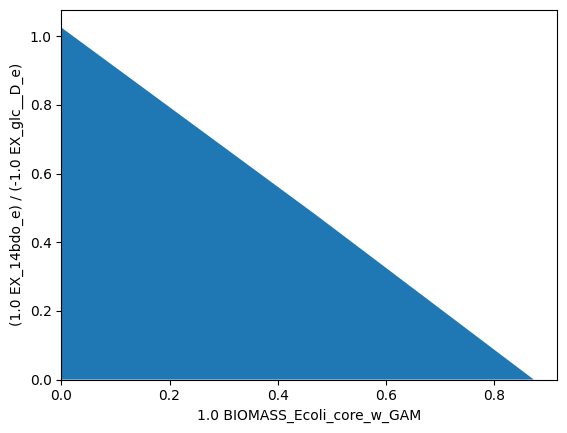

In [2]:
sd.plot_flux_space(ecc_14bdo, ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')));

Bacterial growth seems to compete with 1,4-BDO production. The maximum theoretical 1,4-BDO yield, is slightly above 1. We may now try to set realistic strain design goals. Assuming that knockout sets can be found the force a product yield above 0.3, while a growth rate of 0.2 is still attainable, we can specify according flux subspaces for protection or deletion through inequalities.

Since we decided to enforce a yield above 0.3, we aim to suppress all flux states with a yied inferior to this. Hence, we can describe the subspace of undesired fluxes with the inequality:
$$\frac{v_{1,4-BDO}}{v_{Glc,up}} \le 0.3$$
which can be linearized unter the assumption that $v_{Glc_up}>0$ to:
$$v_{1,4-BDO} - 0.3\, v_{Glc,up} \le 0$$

The flux states, which we aim to protect (at least partically) can be described by:
$$v_{growth} \ge 0.2$$

We can use the plotting function to visualize the flux subspaces that we would like to suppress (orange) or protect (green).

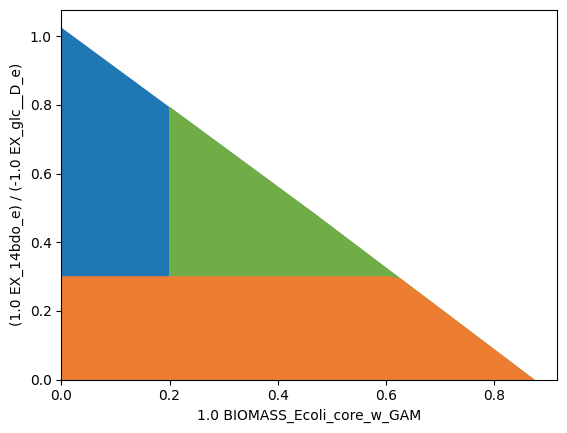

In [3]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.2',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

#### 3) Set up the strain design problem

The StrainDesign package uses so-called "strain design modules" to specify strain design goals. In the case of MCS, the goal is to suppress and protect flux spaces denoted by (sets of) linear inequalities. In the following we specify these modules.

In [4]:
module_suppress = sd.SDModule(ecc_14bdo,sd.SUPPRESS,constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0')
module_protect  = sd.SDModule(ecc_14bdo,sd.PROTECT, constraints='BIOMASS_Ecoli_core_w_GAM>=0.2')

It must be noted that suppressed or protected flux spaces are not only denoted by single inequalities, but are always subspaces of the original model. For instance, the set of flux vectors in the "suppressed" flux space is constrained by the specified inequality
$$v_{1,4-BDO}^{supp} - 0.3\, v_{Glc,up}^{supp} \le 0$$
**but also** by the model constraints
$$\mathbf{S\cdot v^{supp} = 0}$$
$$\mathbf{lb \le v^{supp} \le ub}$$

We must pay close attention when specifying *protect* and *suppress' modules, as, in either case, we avoid to include the zero flux vector $\mathbf{v = 0}$ in the according subspace. If the zero vector were contained in the *suppressed* flux space, the subspace could not be suppressed, since the zero vector can always be attained, even if all reactions were to be blocked. If the zero vector is part of the *protected* flux space, the module will be ineffective, since reactions knockouts can never disrupt this vector. 

In the case of the e_coli_core, it is unnecessary to exclude the zero vector explicitly, since it is already excluded by default due to the minimum ATP maintenance demand. If this was not the case, one would need a auxiliary constraint, e.g., $ v_{Glc,up} \ge 0.1$.

#### 4) Compute strain designs

We can now proceed with the strain design computation. Since we normally don't know if solutions to our strain design problems exist, we will start the computation with the most relaxed settings possible. This means, we compute only one single solution, within a given MILP timelimit of 5 minutes (for genome-scale setups, this should be increased to an hour), while omitting the minimality demand in the solutions and allow up to 30 knockouts. For this initial approach, we also activate logging to follow the progress of the computation.

In [5]:
import logging
logging.basicConfig(level=logging.INFO)
# Compute strain designs
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 time_limit = 300,
                                 max_solutions = 1,
                                 max_cost = 10,
                                 solution_approach = sd.ANY)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example knockout set: {[s for s in sols.reaction_sd[0]]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 62859
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Compressing Network (104 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 61 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Last step could not reduce size further (61 reactions).
INFO:root:  Network compression completed. (1 compression iterations)
INFO:root:  Translating stoichiometric coefficients back to float.
INFO:root:  FVA(s) in compressed model to identify essential reactions.
INFO:root:Finished preprocessing:
INFO:root:  Model size: 61 reactions, 36 metabolites
INFO:root:

One compressed solution with cost 9.0 found and expanded to 12 solutions in the uncompressed netork.
Example knockout set: ['ACALD', 'ATPS4r', 'SUCCt3', 'FORt2', 'NADTRHD', 'PDH', 'CO2t', 'D_LACt2', 'EX_h2o_e']


#### 5) Analyze strain designs

We may plot the computed strain design (yellow) on top of the wild type model (blue), the suppressed fluxes (orange) and the protected fluxes (green). The designed strain is forced to produce 1,4-butanediol but is still able to grow at a rate higher than 0.2 1/h. 

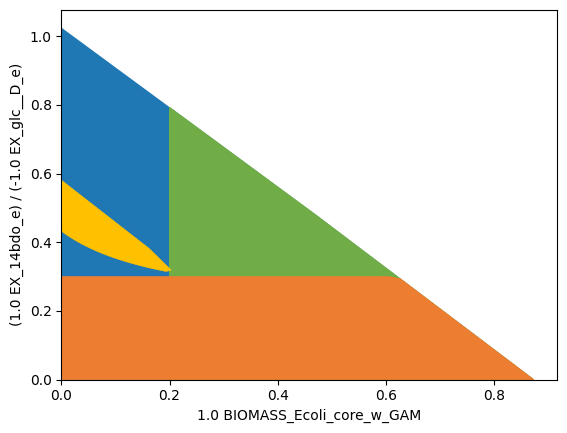

In [6]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.2',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
knockouts = [[{s:1.0},'=',0.0] for s in sols.reaction_sd[0]]
_,          _,      plot4 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=knockouts,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

### Example 1b: gene-KO-based strain designs with 1,4-butanediol SUCP

#### 4) Compute strain designs

An easy way to compute gene-based MCS is to set the ``gene_kos`` parameter to True. All genes then are regarded as knockout candidates.

In [7]:
import logging
logging.basicConfig(level=logging.INFO)
# Compute strain designs
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 time_limit = 300,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 solution_approach = sd.ANY,
                                 gene_kos = True)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example knockout set: {[s for s in sols.gene_sd[0]]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 21836
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 113 genes and 56 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (307 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 164 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 142 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 135 reactions.
INFO:root:  Compression 4: Lumping parallel reac

One compressed solution with cost 11.0 found and expanded to 1 solutions in the uncompressed netork.
Example knockout set: ['pgi', 'kgtP', 'lpd', 'gltP', 'maeA', 'maeB', 'pykF', 'pykA', 'fumC', 'fumA', 'fumB']


#### 5) Analyze (gene-KO-based) strain designs

We may now analyze the resulting strain designs stored in ``sols.gene_sd``. When strain designs were computed with genetic interventions, such interventions need to be translated back to the reaction level in order to enable network analysis tools. This is done automatically at the end of each computation. The reaction-intervention equivalent can be accessed through the field ``sols.reaction_sd``.

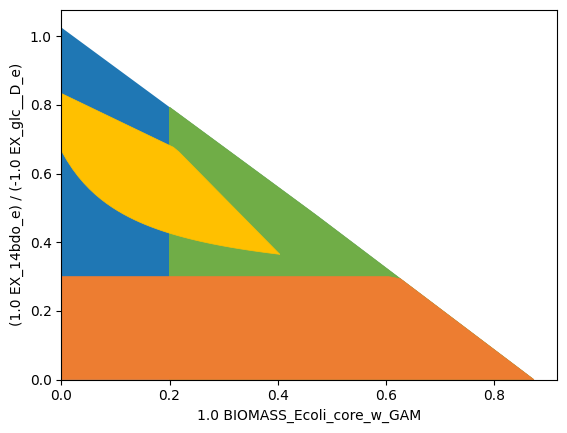

In [8]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.2',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints='EX_14bdo_e + 0.3 EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
knockouts = [[{s:1.0},'=',0.0] for s in sols.reaction_sd[0]]
_,          _,      plot4 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=knockouts,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

As before, the designed strain complies with the specified MCS strain design goals.

### Example 1c: gene-KO, regulatory and reactions-addition-based strain designs with 1,4-butanediol SUCP

#### 4) Compute strain designs with different intervention types

In step (1), we added two pathways that can be used to produce the intermediate succinic semialdehyde branching from alpha-ketoglutarate. In fact, only one reaction, AKGDC or SSCOARx, is needed for producing 1,4-BDO. If we want to save experimental effort, we may want to consider the addition of only one of the two respective enzymes.

For the MCS computation, we will therefore mark the reactions AKGDC and SSCOARx as "addition candidates". The algorithm will now combine a knockout strategy with the addition of one of the two reactions. For this computation example we will:
- relax the strain design demands.
- allow the knockout of all genes (apart from the pseudogene for spontanous reactions)
- allow the knockout of O2, thereby simulating anaerobic conditions
- allow the limitation of O2 uptake down to a rate of below 1
- treat AKGDC and SSCOARx as addition candidates (Instead of reaction additions, one could also use gene-additions. Since the gene-reaction-association is 1:1, the computation results would be identical.). We associate different intervention costs to the addition of these reactions. AKGDC addition has the cost 1, SSCOARx addition has the cost 5.

In [9]:
module_suppress = sd.SDModule(ecc_14bdo,sd.SUPPRESS,constraints='EX_14bdo_e + 0.05 EX_glc__D_e <= 0')
module_protect  = sd.SDModule(ecc_14bdo,sd.PROTECT, constraints='BIOMASS_Ecoli_core_w_GAM>=0.02')

# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# possible throttling of O2 uptake
reg_cost = {'-EX_o2_e <= 1' : 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':5}

# compute strain designs
import logging
logging.basicConfig(level=logging.INFO)
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 max_cost = 9,
                                 solution_approach = sd.POPULATE,
                                 ko_cost = ko_cost,
                                 gko_cost = gko_cost,
                                 reg_cost = reg_cost,
                                 ki_cost = ki_cost)

INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 22847
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 111 genes and 52 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (301 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 155 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 133 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 126 reactions.
INFO:root:  Compression 4: Lumping parallel reac

In [10]:
for i,s in enumerate(sols.gene_sd):
    st = [['+'+t if v>0 else '-'+t][0] for t,v in s.items() if v != 0]
    print('solution '+str(i+1)+': '+', '.join(st))

solution 1: +SSCOARx, -pgi, -EX_o2_e
solution 2: +SSCOARx, -pgi, -cbdB, -cydA
solution 3: +SSCOARx, -pgi, -cbdB, -cydB
solution 4: +AKGDC, -pgi, -kgtP, -gltP, -mdh, -aceA, -pykF, -pykA, -sucC
solution 5: +AKGDC, -pgi, -kgtP, -gltP, -mdh, -aceA, -pykF, -pykA, -sucD
solution 6: +SSCOARx, -pgi, -pflA, -pflD, +-EX_o2_e <= 1
solution 7: +SSCOARx, -pgi, -pflA, -pflC, +-EX_o2_e <= 1
solution 8: +AKGDC, -pgi, -kgtP, -gltP, -mdh, -sucA, -aceA, -pykF, -pykA
solution 9: +AKGDC, -pgi, -kgtP, -gltP, -mdh, -sucB, -aceA, -pykF, -pykA
solution 10: +SSCOARx, -pgi, -cbdA, -cydA
solution 11: +SSCOARx, -pgi, -cbdA, -cydB
solution 12: +SSCOARx, -pgi, -focA, -focB, +-EX_o2_e <= 1
solution 13: +SSCOARx, -pgi, -adhE, -mhpF, +-EX_o2_e <= 1
solution 14: +AKGDC, -pgi, -kgtP, -lpd, -gltP, -mdh, -aceA, -pykF, -pykA


## Example 2: Enforce product (1,4-BDO) synthesis at all growth states (dGCP strain design)

For computing dGCP strain designs with MCS, we follow the identical steps from Example 1:

1) The production pathways, i.e., their metabolites and reactions are added to the model.
2) Analysis tools are used to identify adequate strain design goals. 
3) Set up the according strain design problem by specifying two strain design *modules*, one that demand the suppression of flux states with low product yields, the other one protecting the functions that are essential for bacterial growth.
4) The strain design function is called, passing the model and the strain design module(s) as function arguments.
5) The results are analyzed.

#### 1) Add and verify production pathway (skipped, since identical to Example 1)

#### 2) Analyze model with production envelope 

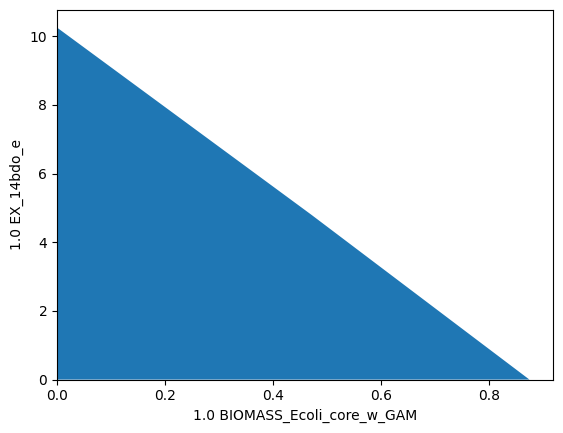

In [11]:
# Plot production envelope
sd.plot_flux_space(ecc_14bdo, ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'));

#### 3) Set up the dGCP strain design modules

For dGCP, we demand that all flux states of microbial growth carry production. Ideally, we want to (a) ensure a minimum ratio of product synthesis rate and growth rate $\frac{v_{product}}{v_{growth}} > Y_{P/BM}^{min}$ (2) ensure that growth is still possible. Hence, we define one suppression and one protection module.

Suppress module (removing flux states, where $\frac{v_{product}}{v_{growth}} \le Y_{P/BM}^{min}$):
$$v_{product} - Y_{P/BM}^{min} v_{growth} \le 0$$
$$v_{growth} \ge 0.01~h^{-1}$$
The latter constraint is used to explicitly exclude the $\mathbf{v=0}$ vector from the suppressed flux states. Here, we use an arbitrary threshold of $Y_{P/BM}^{min} = 5$ that we inferred from the production envelope.

Protect module:
$$v_{growth} \ge 0.2~h^{-1}$$

In [12]:
module_suppress = sd.SDModule(ecc_14bdo,sd.SUPPRESS,constraints=['EX_14bdo_e - 5 BIOMASS_Ecoli_core_w_GAM <= 0', 
                                                                       'BIOMASS_Ecoli_core_w_GAM >= 0.01'])
module_protect  = sd.SDModule(ecc_14bdo,sd.PROTECT, constraints='BIOMASS_Ecoli_core_w_GAM>=0.2')

Plotting the flux spaces in the production envelope returns:

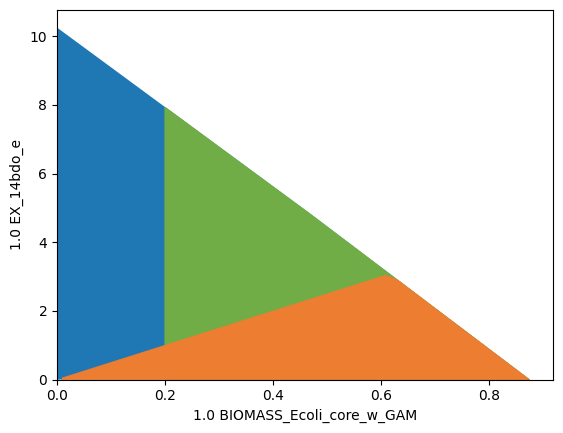

In [13]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.2',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=['EX_14bdo_e - 5 BIOMASS_Ecoli_core_w_GAM <= 0', 
                                                            'BIOMASS_Ecoli_core_w_GAM >= 0.01'],
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

#### 4) Compute strain designs

In [14]:
import logging
logging.basicConfig(level=logging.ERROR)
# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
ki_cost = {'AKGDC':1, 'SSCOARx':1} # AKGDC was added in example 1.c)

# compute strain designs
sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 max_solutions = 1,
                                 max_cost = 30,
                                 solution_approach = sd.BEST,
                                 ko_cost = ko_cost,
                                 gko_cost = gko_cost,
                                 ki_cost = ki_cost)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")
print(f"Knockout set on the reaction level: {[s for s in sols.reaction_sd[0]]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 47779
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 111 genes and 52 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (299 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 153 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 131 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 124 reactions.
INFO:root:  Compression 4: Lumping parallel reac

One compressed solution with cost 6.0 found and expanded to 4 solutions in the uncompressed netork.
Example intervention set: ['+AKGDC', '-kgtP', '-zwf', '-maeB', '-sucC', '-pntB']
Knockout set on the reaction level: ['THD2', 'AKGt2r', 'ME2', 'SUCOAS', 'G6PDH2r', 'AKGDC', 'SSCOARx']


#### 5) Analyze the results

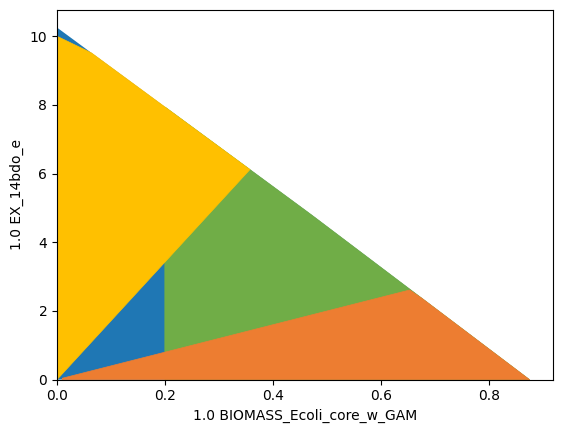

In [15]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.2',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=['EX_14bdo_e - 4 BIOMASS_Ecoli_core_w_GAM <= 0', 
                                                            'BIOMASS_Ecoli_core_w_GAM >= 0.01'],
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot4 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM','EX_14bdo_e'),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

The resulting strain design shows a linear increase of ensured production with increasing growth.

## Example 3: Suppress flux states that are optimal with respect to a pre-defined objective function (wGCP strain design)

The MCS approach also allows the suppression (or protection) of flux vectors that are optimal regarding a pre-defined objective function. With an inner objective function, the SUPPRESS module can be used to disrupt any growth-maximal flux states that don't carry production and thereby enforce - *at least* - weakly growth-coupled production. To avoid lethal knockouts and ensure that growth is still possible at reasonable growth rates, we additionally use a PROTECT region.

Preparing plot of wild type and strain design setup.
Computing MCS.


INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 63305
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 111 genes and 52 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (299 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 153 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 131 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 124 reactions.
INFO:root:  Compression 4: Lumping parallel reac

One compressed solution with cost 4.0 found and expanded to 5 solutions in the uncompressed netork.
Example intervention set: ['+SSCOARx', '-adhE', '-EX_o2_e', '-mhpF']


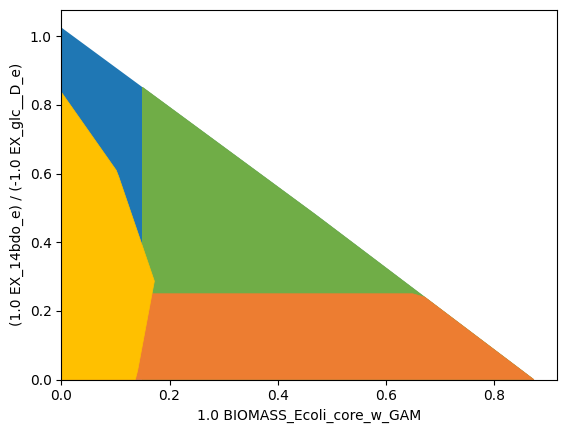

In [16]:
# Wild-type plot
print('Preparing plot of wild type and strain design setup.')
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
# wGCP protect plot
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints='BIOMASS_Ecoli_core_w_GAM>=0.15',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# wGCP suppress plot
_,          _,      plot3 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints='EX_14bdo_e + 0.25 EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')


print('Computing MCS.')
module_wgcp = sd.SDModule(  ecc_14bdo,sd.SUPPRESS,
                            inner_objective='BIOMASS_Ecoli_core_w_GAM',
                            constraints='EX_14bdo_e + 0.25 EX_glc__D_e <= 0')
module_protect = sd.SDModule(  ecc_14bdo,sd.PROTECT,
                            constraints='BIOMASS_Ecoli_core_w_GAM >= 0.15')

# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':1} # AKGDC was added in example 1.c)

sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = [module_wgcp,module_protect],
                                 time_limit = 300,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 gko_cost = gko_cost,
                                 ko_cost = ko_cost,
                                 ki_cost = ki_cost,
                                 solution_approach = sd.BEST)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

# wGCP design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot4 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

As specified by the additional *inner objective function*, product yields inferior to 0.25 (orange) are supressed at growth-maximal flux states, only. At lower growth rates, the strain design *is allowed to have lower product yields*. The protected region, marking healthy growth rates (green), has to be intersected.

## Example 4: Protect flux states that are optimal with respect to a pre-defined objective function (pGCP strain design)

The following setup shows how this function can be used to generate strain designs with at least potentially growth-coupled production. We specify a PROTECT module to ensure that there are growth-maximal flux states with a growth rate of at least 0.4 and a product yield of at least $0.4~\frac{mol_{1,4{\text -}BDO}}{mol_{D{\text -}Glucose}}$.

Preparing plot of wild type and strain design setup.
Computing MCS.


INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 59309
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 86 genes and 49 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (267 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 149 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 128 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 122 reactions.
INFO:root:  Compression 4: Lumping parallel react

One compressed solution with cost 6.0 found and expanded to 2 solutions in the uncompressed netork.
Example intervention set: ['+AKGDC', '-zwf', '-mdh', '-ppsA', '-maeB', '-pntB']


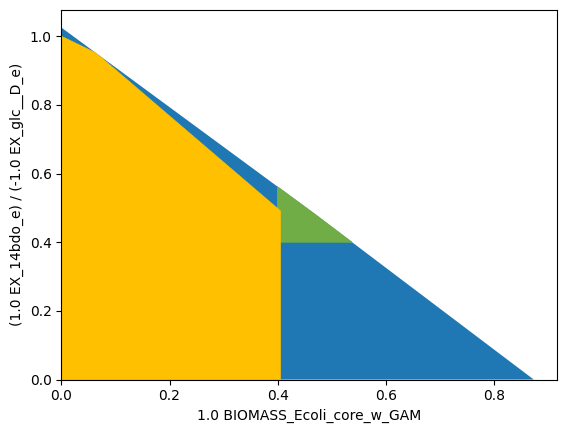

In [17]:
# Wild-type plot
print('Preparing plot of wild type and strain design setup.')
datapoints, triang, plot1 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
# wGCP protect plot
_,          _,      plot2 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints=['BIOMASS_Ecoli_core_w_GAM>=0.4','EX_14bdo_e + 0.4 EX_glc__D_e >= 0'],
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')

print('Computing MCS.')
module_pgcp = sd.SDModule(  ecc_14bdo,sd.PROTECT,
                            inner_objective='BIOMASS_Ecoli_core_w_GAM',
                            constraints=[   'BIOMASS_Ecoli_core_w_GAM >= 0.4',
                                            'EX_14bdo_e + 0.4 EX_glc__D_e >= 0'])

# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in ecc_14bdo.genes}    
gko_cost.pop('s0001')
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# addition candidates
ki_cost = {'AKGDC':1, 'SSCOARx':1} # AKGDC was added in example 1.c)

sols = sd.compute_strain_designs(ecc_14bdo,
                                 sd_modules = module_pgcp,
                                 time_limit = 300,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 gko_cost = gko_cost,
                                 ko_cost = ko_cost,
                                 ki_cost = ki_cost,
                                 solution_approach = sd.BEST)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

# wGCP design plot
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot4 = sd.plot_flux_space(ecc_14bdo,
                                               ('BIOMASS_Ecoli_core_w_GAM',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

The designed strain has potentially growth coupled production. It must be noted that *only one PROTECT region* (green) was used in this computation. Without the *inner objective function*, the wild type strain already fulfills the modules demands, because flux states with simultanous growth and production already exist in the wildtype. In this strain design computation, we enforce that *growth-maximal* flux states exist with growth and product synthesis.

## Example 5: All single gene knockouts that prohibit growth (synthetic lethals).

The MCS approach can be used to identify essential genes. For this type of computation we may use the MCS approach with a single suppress-module that targets flux states of microbial growth, i.e. flux states in which the inequality
$$ v_{Biomass} > 0$$
approximated as
$$ v_{Biomass} \ge 0.001$$
holds. We construct the corresponding module and launch an exhaustive computation of all solutions of the size 1.

In [18]:
# Construct module
module_suppress  = sd.SDModule(ecc,sd.SUPPRESS, constraints='BIOMASS_Ecoli_core_w_GAM>=0.001')
# Compute strain designs
sols = sd.compute_strain_designs(ecc,
                                 sd_modules = module_suppress,
                                 max_cost = 1,
                                 solution_approach = sd.POPULATE,
                                 gene_kos = True)
# Print solutions
print(f"{len(sols.gene_sd)} lethal single gene knockouts were found.")
for i,sol in enumerate(sols.gene_sd):
    print(f"Solution {i+1}: {[s for s in sol][0]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 2364
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (137 genes, 69 gpr rules).
INFO:root:  Simplifyied to 135 genes and 69 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (348 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 198 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 169 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 160 reactions.
INFO:root:  Compression 4: Lumping parallel react

7 lethal single gene knockouts were found.
Solution 1: eno
Solution 2: gapA
Solution 3: icd
Solution 4: pgk
Solution 5: gltA
Solution 6: ptsH
Solution 7: ptsI


<a id='section_6'></a>

## Example 6: Genome-scale strain designs with a minimum product (1,4-butanediol) yield (SUCP strain design)

Supplementary preparation steps are necessary for computing strain designs in a genome-scale setup. Here, we again use the example of enforcing substrat-uptake-coupled production of 1,4-butanediol. 
1) Add production pathways, i.e., metabolites and reactions, to the model.
2) Ensure that only relevant exchange reactions are kept open in the model.
3) Analyze production capacities.
3) Set up the strain design problem through modules.
4) Launch the strain design computation.
5) Analyze the results.

#### 1) Add and verify production pathway

In [19]:
import straindesign as sd
import cobra

cobra.Configuration().solver = 'cplex'
iml = cobra.io.load_model('iML1515')

# Create copy of model to which pathway will be added
iml_14bdo = iml.copy()
# If available, set the solver to cplex or gurobi. This will increase the chances
# of sucess enormously
iml_14bdo.solver = 'cplex'

# Add metabolites to model
iml_14bdo.add_metabolites([ cobra.Metabolite('4hb_c'),   # 4-Hydroxybutanoate
                            cobra.Metabolite('4hbcoa_c'),# 4-Hydroxybutyryl-CoA
                            cobra.Metabolite('4hbal_c'), # 4-Hydroxybutanal
                            cobra.Metabolite('14bdo_c'), # Butane-1,4-diol (cytopl.)
                            cobra.Metabolite('14bdo_p'), # Butane-1,4-diol (peripl.)
                            cobra.Metabolite('14bdo_e')  # Butane-1,4-diol (extrac.)
                            ])

# Create reactions
AKGDC      = cobra.Reaction('AKGDC')
SSCOARx    = cobra.Reaction('SSCOARx')
HBD        = cobra.Reaction('4HBD')
HBCT       = cobra.Reaction('4HBCT')
HBDH       = cobra.Reaction('4HBDH')
HBDx       = cobra.Reaction('4HBDx')
BDOtpp     = cobra.Reaction('14BDOtpp')
BDOtex     = cobra.Reaction('14BDOtex')
EX_14bdo_e = cobra.Reaction('EX_14bdo_e')

# Add reactions to model
iml_14bdo.add_reactions([SSCOARx,
                         AKGDC,
                         HBD,
                         HBCT,
                         HBDH,
                         HBDx,
                         BDOtpp,
                         BDOtex,
                         EX_14bdo_e])

# Define reaction equations
SSCOARx.reaction    = '1 h_c + 1 nadph_c + 1 succoa_c -> 1 coa_c + 1 nadp_c + 1 sucsal_c'
AKGDC.reaction      = '1 akg_c + 1 h_c -> 1 co2_c + 1 sucsal_c'
HBD.reaction        = '1 h_c + 1 nadh_c + 1 sucsal_c  -> 1 4hb_c + 1 nad_c'
HBCT.reaction       = '1 4hb_c + 1 accoa_c            -> 1 4hbcoa_c + 1 ac_c'
HBDH.reaction       = '1 4hbcoa_c + 1 h_c + 1 nadh_c  -> 1 4hbal_c + 1 coa_c + 1 nad_c'
HBDx.reaction       = '1 4hbal_c + 1 h_c + 1 nadh_c   -> 1 14bdo_c + 1 nad_c'
BDOtpp.reaction     = '1 14bdo_c                      -> 1 14bdo_p'
BDOtex.reaction     = '1 14bdo_p                      -> 1 14bdo_e'
EX_14bdo_e.reaction = '1 14bdo_e                      ->'

# define GPR rules for knock-inable genes
SSCOARx.gene_reaction_rule  = 'gsscoar'
AKGDC.gene_reaction_rule    = 'gakgdc'
iml_14bdo.genes.gsscoar.name = 'sscoar'
iml_14bdo.genes.gakgdc.name = 'akgdc'

# Verify that pathway is operational
sol = sd.fba(iml_14bdo,obj='EX_14bdo_e',obj_sense='max')
print(f"Maximum possible 1,4-BDO synthesis rate: {sol.objective_value}.")

Maximum possible 1,4-BDO synthesis rate: 10.489195402311951.


#### 2) Close irrelevant exchange reactions and simplify GPR rules

The iML1515 model contains metabolite exchange capacities that are usually not observed in experiments such as exchanges of CoA-associated or phosphorylated metabolites. While unrealistic, these exchanges are still represented in the model and stoichiometrically possible, hence the MCS approach would have to target many of them in order to enforce SUCP of 1,4-BDO. Closing unrealistic exchanges ahead of the computation reduces the computation effort and aviods the excessive introduction of interventions.

We block the import of all carbon-containing metabolites apart from D-glucose.

We here opt to block the export of all metabolites apart from CO2, Ethanol, Acetate, Formate, D-Lactate, Succinate, Methanol, O2, H+, H2, H2O2 and tungsten. We furthermore allow a number of exchange reactions with the prefix DM_ that are required for the iML biomass synthesis pseudoreaction. 

We replace long and complex GPR rules with shorter ones. The integrated compression routine would compresses GPR rules, which would allow a fast computation. However decompression of computed strain designs can result in countless equivalent strain designs. For instance, the simultanous knockouts of CYTBO3_4pp (cyoA & cyoB & cyoC & cyoD) and FRD2 (frdA & frdB & frdC & frdD) can be achieved by any KO combination of the subunits and hence by permutations (cyoA, frdA) or (cyoA, frdB) or (cyoB, frdA) and so on ... This is an effect we try to minimize by substituting GPR rules.

In [20]:
exchange_reacs = [r for r in iml_14bdo.reactions if all(s<0 for s in r.metabolites.values())]
# shut all exchange fluxes
for r in exchange_reacs:
    r.upper_bound = 0.0

# shut CO2 uptake
iml_14bdo.reactions.EX_co2_e.lower_bound    = 0.0

# keep main fermentation products open
iml_14bdo.reactions.EX_14bdo_e.upper_bound  = 1000.0
iml_14bdo.reactions.EX_ac_e.upper_bound     = 1000.0
iml_14bdo.reactions.EX_co2_e.upper_bound    = 1000.0
iml_14bdo.reactions.EX_etoh_e.upper_bound   = 1000.0
iml_14bdo.reactions.EX_for_e.upper_bound    = 1000.0
iml_14bdo.reactions.EX_h2_e.upper_bound     = 1000.0
iml_14bdo.reactions.EX_h2o2_e.upper_bound   = 1000.0
iml_14bdo.reactions.EX_h2o_e.upper_bound    = 1000.0
iml_14bdo.reactions.EX_h_e.upper_bound      = 1000.0
iml_14bdo.reactions.EX_lac__D_e.upper_bound = 1000.0
iml_14bdo.reactions.EX_meoh_e.upper_bound   = 1000.0
iml_14bdo.reactions.EX_o2_e.upper_bound     = 1000.0
iml_14bdo.reactions.EX_succ_e.upper_bound   = 1000.0
iml_14bdo.reactions.EX_tungs_e.upper_bound  = 1000.0
iml_14bdo.reactions.DM_4crsol_c.upper_bound = 1000.0
iml_14bdo.reactions.DM_5drib_c.upper_bound  = 1000.0
iml_14bdo.reactions.DM_aacald_c.upper_bound = 1000.0
iml_14bdo.reactions.DM_amob_c.upper_bound   = 1000.0
iml_14bdo.reactions.DM_mththf_c.upper_bound = 1000.0
iml_14bdo.reactions.DM_oxam_c.upper_bound   = 1000.0

# substitute GPR rule in ATPS4rpp (all genes occur only in ATPS)
atps_genes = [g for g in iml_14bdo.reactions.ATPS4rpp.genes]
iml_14bdo.reactions.ATPS4rpp.gene_reaction_rule = str(atps_genes[0])
cobra.manipulation.remove_genes(iml_14bdo,atps_genes[1:])
atps_genes[0].name = 'atpX'

# substitute GPR rules in NADH16pp, NADH17pp, NADH18pp (all genes occur only in NADHxxpp and GPR rules are identical)
nuo_genes = [g for g in iml_14bdo.reactions.NADH16pp.genes]
iml_14bdo.reactions.NADH16pp.gene_reaction_rule = str(nuo_genes[0])
iml_14bdo.reactions.NADH17pp.gene_reaction_rule = str(nuo_genes[0])
iml_14bdo.reactions.NADH18pp.gene_reaction_rule = str(nuo_genes[0])
cobra.manipulation.remove_genes(iml_14bdo,nuo_genes[1:])
nuo_genes[0].name = 'nuoX'

# substitute GPR rules in FRD2, FRD3 (genes occur only in FRD2 and FRD3 and GPR rules are identical)
frd_genes = [g for g in iml_14bdo.reactions.FRD2.genes]
iml_14bdo.reactions.FRD2.gene_reaction_rule = str(frd_genes[0])
iml_14bdo.reactions.FRD3.gene_reaction_rule = str(frd_genes[0])
cobra.manipulation.remove_genes(iml_14bdo,frd_genes[1:])
frd_genes[0].name = 'frdX'

# substitute GPR rule in CYTBO3_4pp
cyo_genes = [g for g in iml_14bdo.reactions.CYTBO3_4pp.genes]
iml_14bdo.reactions.CYTBO3_4pp.gene_reaction_rule = str(cyo_genes[0])
cobra.manipulation.remove_genes(iml_14bdo,cyo_genes[1:])
cyo_genes[0].name = 'cyoX'

# substitute GPR rule in THD2pp
pnt_genes = [g for g in iml_14bdo.reactions.THD2pp.genes]
iml_14bdo.reactions.THD2pp.gene_reaction_rule = str(pnt_genes[0])
cobra.manipulation.remove_genes(iml_14bdo,pnt_genes[1:])
pnt_genes[0].name = 'pntX'

# substitute GPR rule in PDH and AKGDH
ace_genes = [g for g in iml_14bdo.genes if g.name in ['aceE', 'aceF']]
sucAB_genes = [g for g in iml_14bdo.genes if g.name in ['sucA', 'sucB']]
lpd = [g for g in iml_14bdo.genes if g.name == 'lpd'][0]
iml_14bdo.reactions.PDH.gene_reaction_rule = str(ace_genes[0])+' and '+str(lpd)
iml_14bdo.reactions.AKGDH.gene_reaction_rule = str(sucAB_genes[0])+' and '+str(lpd)
cobra.manipulation.remove_genes(iml_14bdo,ace_genes[1:])
cobra.manipulation.remove_genes(iml_14bdo,sucAB_genes[1:])
ace_genes[0].name = 'aceEF'
sucAB_genes[0].name = 'sucAB'

# substitute GPR rule in SUCOAS
sucCD_genes = [g for g in iml_14bdo.reactions.SUCOAS.genes]
iml_14bdo.reactions.SUCOAS.gene_reaction_rule = str(sucCD_genes[0])
cobra.manipulation.remove_genes(iml_14bdo,sucCD_genes[1:])
sucCD_genes[0].name = 'sucCD'

# substitute GPR rule in SUCDi
sdh_genes = [g for g in iml_14bdo.reactions.SUCDi.genes]
iml_14bdo.reactions.SUCDi.gene_reaction_rule = str(sdh_genes[0])
cobra.manipulation.remove_genes(iml_14bdo,sdh_genes[1:])
sdh_genes[0].name = 'sdhX'

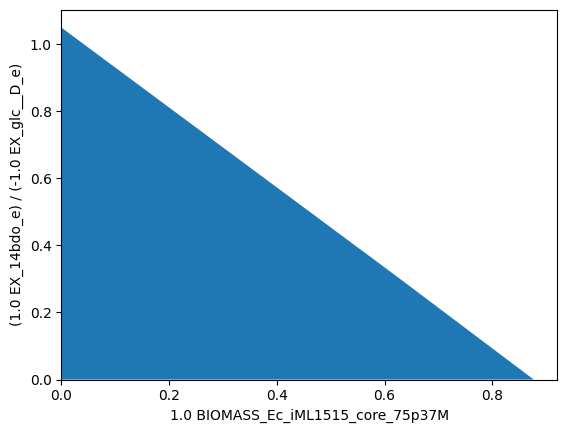

In [21]:
sd.plot_flux_space(iml_14bdo, ('BIOMASS_Ec_iML1515_core_75p37M',('EX_14bdo_e','-EX_glc__D_e')));

#### 3) Set up the strain design problem

As in the small-scale setup, we set up again the SUPRESS and PROTECT modules to enforce substrate-uptake-coupled production of 1,4-BDO. The genome-scale model contains many more secondary pathways that can be used to disrupt SUCP. We therefore start with a conservative setup of demanding a minimum product yield of $0.1~\frac{{mol}_{1,4{\text -}BDO}}{{mol_{D{\text -}Glucose}}}$. At the same time we ensure that growth is still possible at rates of $0.05~h^{-1}$ and above.

In [22]:
min_14bdo_yield = 0.25
min_growth = 0.1
module_suppress = sd.SDModule(iml_14bdo,sd.SUPPRESS,constraints=f'EX_14bdo_e + {min_14bdo_yield} EX_glc__D_e <= 0')
module_protect  = sd.SDModule(iml_14bdo,sd.PROTECT, constraints=f'BIOMASS_Ec_iML1515_core_75p37M>={min_growth}')

Plotted:

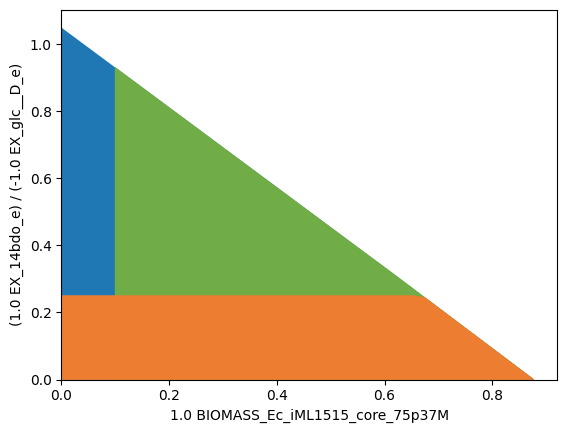

In [23]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(iml_14bdo,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(iml_14bdo,
                                               (f'BIOMASS_Ec_iML1515_core_75p37M',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints=f'BIOMASS_Ec_iML1515_core_75p37M >= {min_growth}',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(iml_14bdo,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=f'EX_14bdo_e + {min_14bdo_yield} EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

In the genome-case setup using iML1515, it is still unnecessary to exclude the 0-vector explicitly, since it is already excluded by default due to the minimum ATP maintenance demand.

#### 4) Compute strain designs

We can now proceed with the strain design computation. Since we normally don't know if solutions to our strain design problems exist, and even more so in genome-scale setups, we will start the computation with the most relaxed settings possible. This means, we compute only one single solution, without a time limit, while omitting the minimality demand in the solutions and allow up to 25 knockouts. We also activate logging to follow the progress of the computation.
If this computation is not successful on the first run, we should retry. The success of genome-scale computations often depends on the MILP search tree, whose construction varies with different computation seeds. A repeated computation may therefore conclude in a different (but also valid) strain design solution. Generally, it is possible that a computation completes in a couple of minutes, while the repetitions runs into timeout.

In [24]:
import logging
logging.basicConfig(level=logging.INFO)

# allow all gene knockouts except for spontanuos 
gko_cost = {g.name:1 for g in iml_14bdo.genes}    
gko_cost.pop('s0001')
gko_cost.pop('akgdc')
gko_cost.pop('sscoar')
# allow knock-in of akgdc and sscoar
gki_cost = {'akgdc':1, 'sscoar':1}
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# Compute strain designs
sols = sd.compute_strain_designs(iml_14bdo,
                                 sd_modules = [module_suppress, module_protect],
                                 max_solutions = 1,
                                 max_cost = 40,
                                 ko_cost = ko_cost,
                                 gko_cost = gko_cost,
                                 gki_cost = gki_cost,
                                 solution_approach = sd.ANY)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 3183
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (1485 genes, 2268 gpr rules).
INFO:root:  Simplifyied to 1229 genes and 1853 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
INFO:root:Compressing Network (5252 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 2450 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 2341 reactions.
INFO:root:  Compression 3: Applying compression from EFM-tool module.
INFO:root:  Reduced to 2298 reactions.
INFO:root:  Compression 4: Lumping para

One compressed solution with cost 13.0 found and expanded to 1 solutions in the uncompressed netork.
Example intervention set: ['-EX_o2_e', '-adhE', '-yqhD', '-aldB', '-ahr', '-mdh', '-pntX', '+sscoar', '-adhP', '-ybbO', '-yghA', '-glcA', '-lldP']


#### 5) Analyze strain designs

We may plot the computed strain design (yellow) on top of the wild type model (blue), the suppressed fluxes (orange) and the protected fluxes (green). The designed strain is forced to produce 1,4-butanediol but is still able to grow at a relatively high rate. 

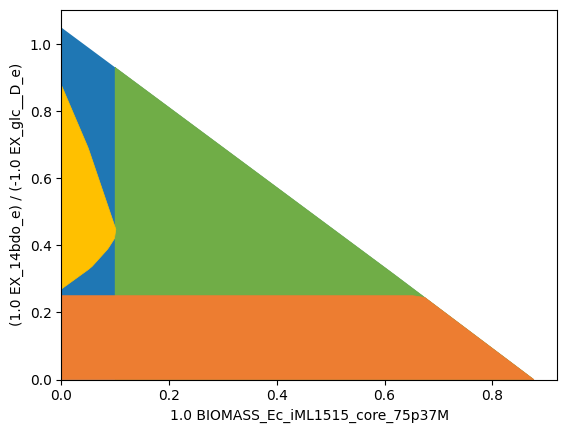

In [25]:
import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(iml_14bdo,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_14bdo_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(iml_14bdo,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_14bdo_e','-EX_glc__D_e')),
                                               constraints=f'BIOMASS_Ec_iML1515_core_75p37M>={min_growth}',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(iml_14bdo,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=f'EX_14bdo_e + {min_14bdo_yield} EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot4 = sd.plot_flux_space(iml_14bdo,
                                               ('BIOMASS_Ec_iML1515_core_75p37M',('EX_14bdo_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

MCS suggests the addition of only one of the two enzymes SSCOAR or AKGDC and suggests the knockout of plenty of other genes. The knockout suggestions proposed by MCS are often overly conservative. In practice, a subset of knockouts is sufficient, in particular, knockouts may be unnecessary when the affected pathway does not carry a large flux in the first place.

<a id='section_7'></a>

## Example 7: Suppress flux states in a toy network

The MCS concept can be showcased in a small example network:

<img style="float:left; width:20%" src="../img/SmallExample.svg" />

Suppose, we want block all metabolic flux through **R4** to avoid the production of metabolite **E**. One can now identify irreducible sets of reaction knockouts to achieve this. Each of these set is called a minimal cut set, short MCS. This figure shows all possible MCS for blocking reaction R4.

<img style="float:left; width:70%" src="../img/SmallExample_mcs1.svg" />


Set up the according strain design problem by specifying a *module* that demands the suppression of flux states with $R4 > 0$. 

Since strict inequalities are not allowed in mixed integer linear programming (MILP), we need to approximate it by an inclusive inequality and a sufficiently small value $\varepsilon>0$. Here we pick $\varepsilon=1$, such that the flux states that we aim to delete are those that fulfill the inequality:

$$R4 >= 1$$

In [26]:
modules  =  [sd.SDModule(model,sd.SUPPRESS,constraints='R4 >= 1')]
# modules +=  [sd.SDModule(model,sd.PROTECT, constraints='R3 >= 1')]


sols = sd.compute_strain_designs(model,sd_modules = modules)
for s in sols.reaction_sd:
    print(s)

INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 4983
INFO:root:  Using cplex for solving LPs during preprocessing.


INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Compressing Network (10 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 8 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Last step could not reduce size further (8 reactions).
INFO:root:  Network compression completed. (1 compression iterations)
INFO:root:  Translating stoichiometric coefficients back to float.
INFO:root:  FVA(s) in compressed model to identify essential reactions.
INFO:root:Finished preprocessing:
INFO:root:  Model size: 8 reactions, 4 metabolites
INFO:root:  8 targetable reactions
INFO:root:Constructing strain design MILP for solver: cplex.
INFO:root:  Bounding MILP.
INFO:root:Finding optimal strain desi

{'R1': -1.0}
{'R3': -1.0}
{'R4': -1.0}
{'R7': -1.0}
{'R10': -1.0}
{'R6': -1.0, 'R8': -1.0}
{'R2': -1.0, 'R5': -1.0, 'R6': -1.0}


An adequate value for $\varepsilon$ can inferred from the model, i.e., the coefficients of the stoichiometric matrix and the flux boundaries. In the shown example values of 1e-7 up to 50 will yield the same results. However, too small values may result in longer runtimes or numerical issues. While large values may not approximate the strict inequality well enough.

<a id='section_8'></a>

## Example 8: Suppress and protect flux states in a toy network

It may sometimes be required to protect certain flux states, for instance, to guarantee that the model stays feasible despite the deletion, or to guarantee that microbial growth is still possible despite the introduced where **R4** must be deleted and additionally demand that **R3** must still be able to carry flux.

In [27]:
import straindesign as sd
import cobra

model = cobra.io.read_sbml_model('../../../tests/model_small_example.xml')

modules =   [sd.SDModule(model,sd.SUPPRESS,constraints='R4 >= 1')]
modules +=  [sd.SDModule(model,sd.PROTECT, constraints='R3 >= 1')]

sols = sd.compute_strain_designs(model,sd_modules = modules)
for s in sols.reaction_sd:
    print(s)

INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 47615
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Compressing Network (10 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 8 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Last step could not reduce size further (8 reactions).
INFO:root:  Network compression completed. (1 compression iterations)
INFO:root:  Translating stoichiometric coefficients back to float.
INFO:root:  FVA(s) in compressed model to identify essential reactions.
INFO:root:Finished preprocessing:
INFO:root:  Model size: 8 reactions, 4 metabolites
INFO:root:  7 t

{'R1': -1.0}
{'R4': -1.0}
{'R7': -1.0}
{'R10': -1.0}
{'R6': -1.0, 'R8': -1.0}


As can be seen, the computation returns the 5 out of 7 MCS that block R4 but not R3. The set of theses *constrained* MCS (cMCS) is a subset of the former MCS solution pool.

<img style="float:left; width:70%" src="../img/SmallExample_mcs2.svg" />

## Theoretical background

In the simplest case, the Minimal Cut Set approach seeks to identify the smallest set of knockouts that render undesired flux states, such as flux states with poor productivity or yield, unattainable. In reference to the space of steady-state flux vectors: one introduces *knockouts that exclude a certain flux-subspace from the space of feasible flux states*. 

(Mixed integer) linear programming operates on *feasible* problem spaces and, *per se*, does not allow sub-problems to be infeasible. To express the infeasibility of a certain sub-problem, one needs to formulate an equivalent but "mirrored" problem whose feasibility under any conditions coincides with the infeasibility of the original problem. Farkas' Lemma is a theorem that will serve for exactly that purpose. It states that, to a system of linear inequalities, a second system of linear inequalities can be defined such that *one and only one* of the two problems is feasible. We call the original system the primary and secondary system the Farkas-dual. The feasibility of one problem is a *certificate for the infeasibility* of the other one.

$$
\begin{gathered}
    \text{Exactly one of the following is true:\hspace{7em}} ~\\~
    \mathbf{A \, x\le b} \qquad \qquad \text{or} \qquad \qquad \mathbf{A^\intercal y=0,\quad y\ge0, \quad y^\intercal b<}\,0.
\end{gathered}
$$

Farkas-duality is closely related to Lagrange-duality in Linear Progamming and variables in one problem correspond to constraints in the other. When we introduce interventions (i.e., we force certain flux variables to take the value 0), we need to adapt the Farkas-dual that we use in the MCS-MILP accordingly. When a variable is more constrained in one problem (or fixed to zero), the other problem relaxes in the corresponding constraint (up to the complete lifting of the constraint).

In the following we show how Farkas' Lemma can be used to construct the MCS-MILP. We start with the original MCS-system simplified as $\mathbf{A_T\cdot x=0\le b_T}$ that is rendered infeasible through the introduction of knockouts as additional constraints. 

$$
\begin{gathered}
    \begin{bmatrix}
        \mathbf{A_T} \\
        \mathbf{I_{KO}}
    \end{bmatrix} 
    \mathbf{x} ~
    \begin{matrix}
        \le \\ =
    \end{matrix}
    \begin{bmatrix}\mathbf{b_T} \\ \mathbf{0}\end{bmatrix}\hskip -0.2em.
\end{gathered}
$$

The introduced permanent knockouts will later be controlled through binary decision variables. It must be noted that the constraints only render the primal system infeasible when they *contradict* the primal system. As was mentioned above, it is therefore not possible to use undesired systems that have the zero vector $\mathbf{x=0}$ as a feasible solution because then even the knockout of all reactions would not make the primal system infeasible. 

Using Farkas-dualization, the dual system is given by:

$$
\begin{gathered}
    \begin{bmatrix}
        \mathbf{A_T^\intercal} & \mathbf{I_{KO}} \\
        \mathbf{b_T^\intercal} & \mathbf{0}
    \end{bmatrix} 
    \begin{bmatrix}
        \mathbf{y} \\ \mathbf{v}
    \end{bmatrix}
    \begin{matrix}
    = \\ \le
    \end{matrix}
    \begin{bmatrix}\mathbf{0} \\ -1 \end{bmatrix}\\
    \mathbf{y\ge 0},
\end{gathered}
$$

which is, per definition, feasible. The single inequality in the last row corresponds to $\mathbf{b^\intercal y<}0$ of the Farkas-dual system. The latter needs to be replaced with $\mathbf{b_T^\intercal y\le}-1$ because the system will later be used in a MILP that cannot handle strict inequalities. The replacement is allowed because any found solution of the Farkas-dual can be scaled to also fulfill $\mathbf{b_T^\intercal y\le}-1$ without affecting the support of the solution (which makes up the MCS).

As can be seen, the variable knockouts in the primal ($\mathbf{I_{KO}\, x=0}$) translate to the variables $\mathbf{v}$ in the Farkas-dual system that mime the knockout of all dual constraints by allowing for arbitrary large slack. This system can now be used to identify MCS, since a minimal subset of constraint relaxations (indicated by $v_i\ne 0$) that solves the Farkas-dual system corresponds directly to a minimal subset of primal knockout-constraints within $\mathbf{I_{KO}\, x=0}$ that keeps the primal system infeasible. Hence, every solution of the problem with a support-minimal vector $\mathbf{v}$ represents one MCS.

A constraint can be switched on or off by controlling its slack variable $v_i$ by a corresponding binary variable $z_i$ either via indicator constraints, 
$$
	z_i = 0 \rightarrow v_i = 0,
$$

or with the big-M method (with M being a sufficiently large number) 

$$
	-M\cdot z_i \le v_i \le M\cdot z_i.
$$

In this case, there is a 1:1 association of metabolic knockouts, indicated by $z_i$ and slack variables $v_i$. With the binary variables $z_i$  at hand, we may now finally pose a MILP problem with an objective function that minimizes the number of interventions to block the target system (we use here the version with indicator constraints): 
$$
\begin{array}{l c}
	\text{minimize} \; & \sum z_i \\
	\text{subject to}  &
	\begin{gathered}
		\begin{bmatrix}
			\mathbf{A_T^\intercal} & \mathbf{I_{KO}} \\
			\mathbf{b_T^\intercal} & \mathbf{0}
		\end{bmatrix} 
		\begin{bmatrix}
			\mathbf{y} \\ \mathbf{v}
		\end{bmatrix}
		\begin{matrix}
			= \\ \le
		\end{matrix}
		\begin{bmatrix}\mathbf{0} \\ -1 \end{bmatrix}\\
		\forall i: z_i = 0 \rightarrow v_i = 0 \\
		\mathbf{y\ge 0}, \,  \hskip 1em  z_i \in \{0,1\}.
	\end{gathered} 
\end{array}
$$

This MILP finds the smallest irreducible set of interventions (support-minimal in $\mathbf{v}$) that blocks the target system, hence an MCS with the smallest possible cardinality.

We note that an even more concise formulation can be constructed by omitting the slack-variables $v_i$ and linking the removal of constraints directly to $z_i$:

$$
	\begin{array}{l c}
		\text{minimize} \; & \sum z_i \\
		\text{subject to} &
		\begin{gathered}[t]
			\begin{bmatrix}
				\mathbf{b_T^\intercal} & \mathbf{0} \\
				\mathbf{0} 			  & \mathbf{A_D} 
			\end{bmatrix}  
			\begin{bmatrix}
				\mathbf{y} \\ \mathbf{x}
			\end{bmatrix}
			\begin{matrix}
				\le \\ \le
			\end{matrix}
			\begin{bmatrix} -1 \\ \mathbf{b_D} \end{bmatrix}\\
			\forall i: z_i = 0 \rightarrow \mathbf{A_{T\mathnormal{,i}}^\intercal y} = 0 \\
			\forall i: z_i = 1 \rightarrow x_i = 0 \\
			\mathbf{y\ge 0}, \,  \hskip 1em  z_i \in \{0,1\}.
		\end{gathered} 
	\end{array}
$$

The MCS $S$ (containing the indices of the knocked-out reactions), computed by the MILP, is given by $S=\{i|z_i=1\}$. Multiple MCS solutions (with increasing cardinality) can be found by excluding previously found solutions and their supersets through integer cut constraints and solving the MILP repeatedly.